In questo tutorial cercheremo di identificare la presenza di Covariate Shift e cercheremo di implementare un primo metodo di correzione.

Il modello di classificazione utilizzato è un **Random Forest**. Questo è un modello di Machine Learning supervisionato, cioè viene addestrato utilizzando un insieme di dati di cui si conosce a priori il valore da predirre. 

E' chiamata _foresta_ perchè è costituito da una serie di più modelli chiamati **Decision Tree**, alberi decisionali ognuno dei quali predisposto a prendere una decisione (previsione) su un determinato set di dati. I dati di questi alberi vengono poi fusi insieme per assicurare previsioni più accurate.

In [16]:
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold as SKF
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import roc_auc_score, accuracy_score
from matplotlib import pyplot as plt

Creiamo un dataset di training (**train**) ed un dataset di testing (**test**) a partire da una distribuzione normale. Entrambi i dataset saranno formati da due colonne (**features**).

Il dataset di training è chiamato così perchè viene utilizzato per addestrare l'algoritmo di classificazione. Il modello apprenderà come classificare i record in base a ciò che apprenderà dal modello di training. 
Dall'altra parte il dataset di test è utilizzato per verificare se il modello addestrato ottiene buoni risultati anche su dati non ancora visti.

In [2]:
# np.random.normal permette di creare un array formato da una selezione 
# valori provenienti da una distribuzione normale, cioè una distribuzione
# i cui valori tendono a concentrarsi in egual misura intorno 
# ad un valore medio (media)
train_feat_1 = np.random.normal(2.8, 1, 1000)
train_feat_2 = np.random.normal(5, .3, 1000)


test_feat_1 = np.random.normal(3.5, 1.5, 1000) #4, 1
test_feat_2 = np.random.normal(5.6, .3, 1000)

# la funzione np.c_ permette di concatenare per colonna più array
X_train = np.c_[train_feat_1, train_feat_2]
X_test = np.c_[test_feat_1, test_feat_2]


In [3]:
X_train.shape

(1000, 2)

I grafici in basso mostrano che le fiture su entrambi i dataset hanno distribuzioni simili per quel che riguarda la variabilità (**varianza**) ma la distribuzione dei dati di test sembra essere _spostata_ sulla destra (**shift**)

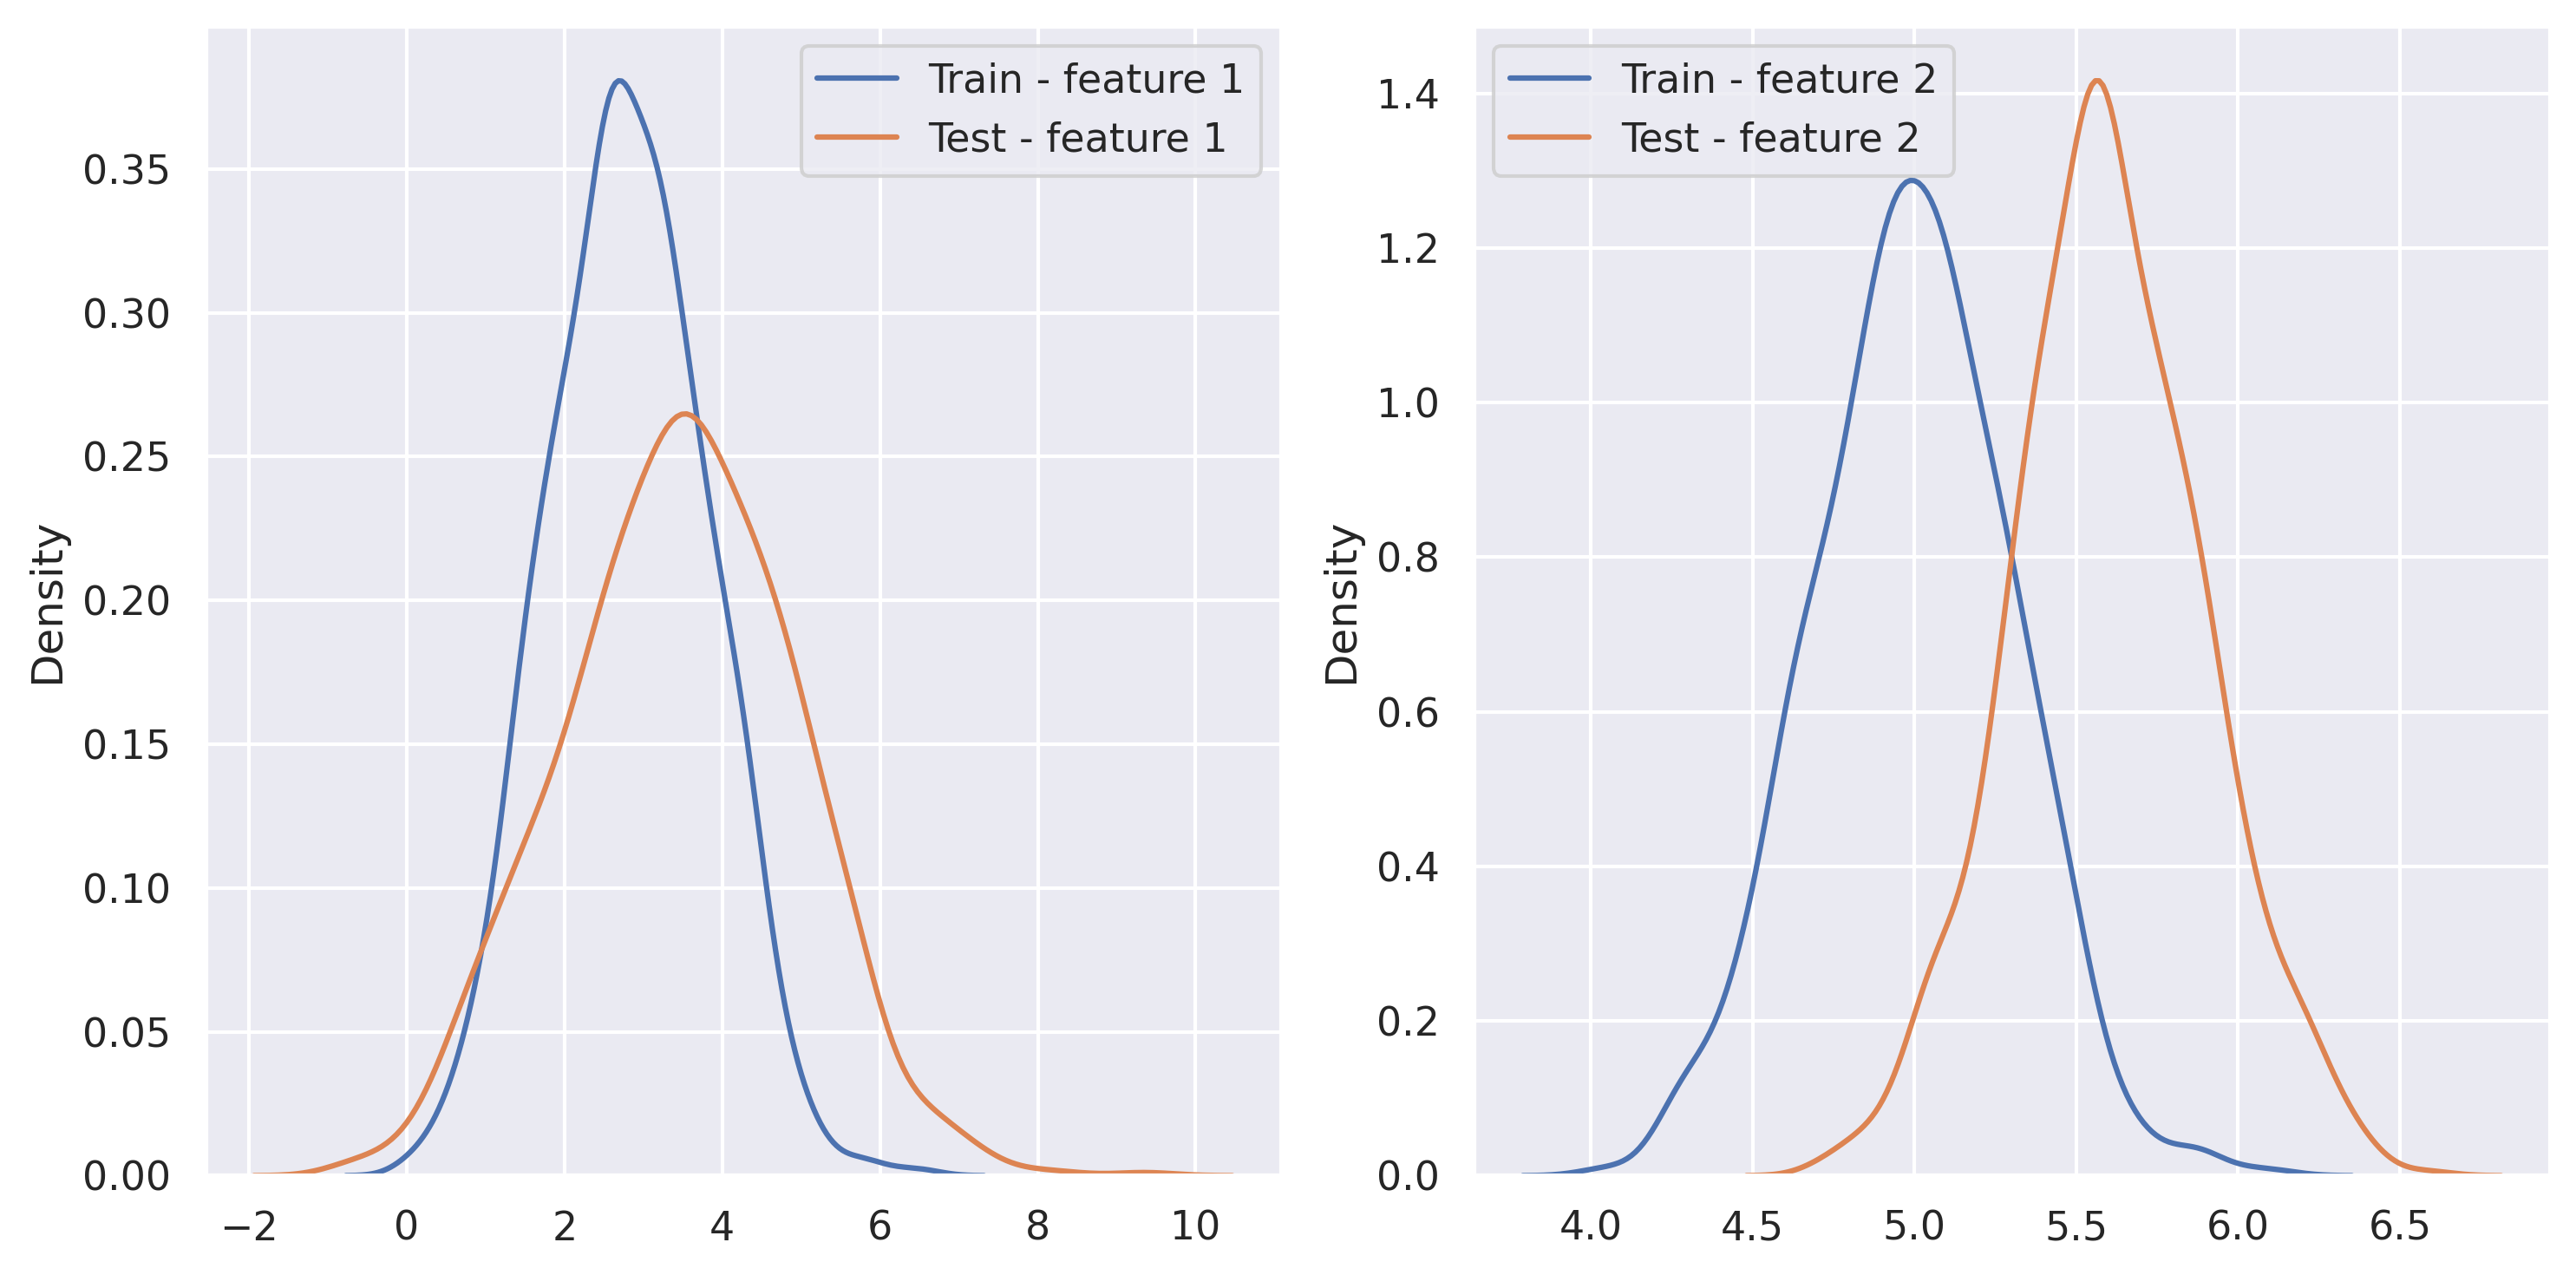

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), dpi=300)

for i in range(X_train.shape[1]):

  # kdeplot permette di rappresentare graficamente la distribuzione dei dati
  # utilizzando la curva di densità di probabilità
  sns.kdeplot(X_train[:,i], ax=axs[i], label=f'Train - feature {i+1}')
  sns.kdeplot(X_test[:,i], ax=axs[i], label=f'Test - feature {i+1}')
  axs[i].legend()
fig.tight_layout()


Anche la distribuzione dei punti sul piano cartesiano mostra i valori del dataset di Test che non si sovrappongono ai valori del dataset di Training

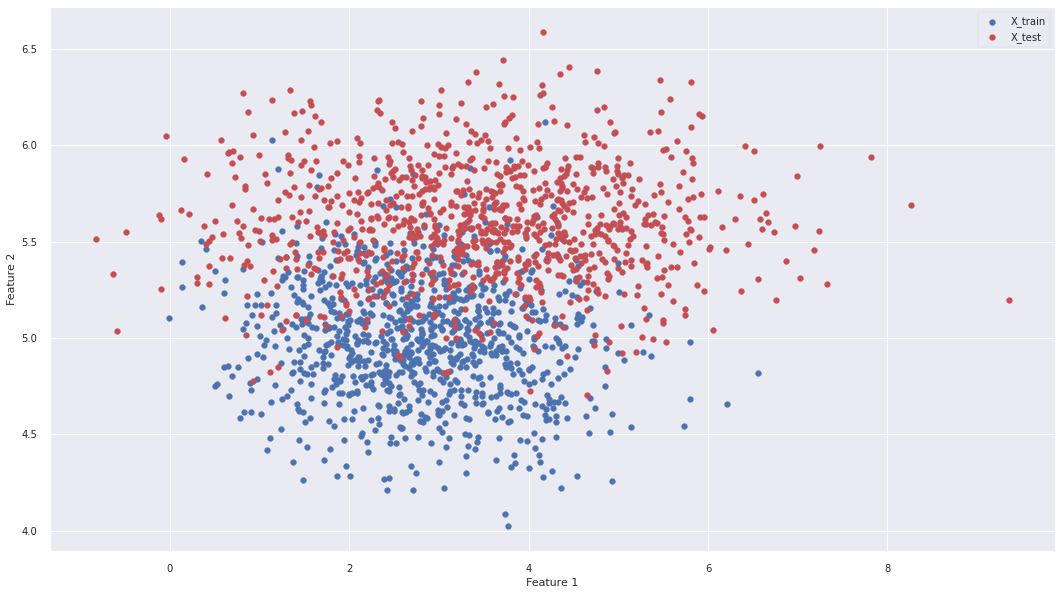

In [5]:
plt.ion()
plt.style.use('seaborn-notebook')
fig = plt.gcf()
fig.patch.set_facecolor('white')
fig.set_size_inches((18,10))
fig.set_facecolor("w")
ax = fig.add_subplot(111)

# scatter plot permette di rappresentare su un piano bi-dimensionale i valori
# di un dataset
plt.scatter(X_train[:,0], X_train[:,1], marker='o', s=35, c='b', label='X_train')
plt.scatter(X_test[:,0], X_test[:,1], marker='o', s=35, c='r', label='X_test')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

Creiamo un unido dataset, concatenando i dati di Training ed i dati di Test. Nel far questo creiamo una nuova variabile _is_train_ che assumerà valore 1 per tutti i record appartenenti al dataset di training e valore 0 per tutti i record appartenenti al dataset di test

In [20]:
df_train = pd.DataFrame(X_train, columns=['feature_1', 'feature_2'])
df_test = pd.DataFrame(X_test, columns=['feature_1', 'feature_2'])
df_train['is_train'] = 1 # 1 per i dati di training
df_test['is_train'] = 0 # 0 per i dati di test
df_train_test = pd.concat( [df_train, df_test], ignore_index=True, axis=0)

In [22]:
df_train_test.head(10)

,feature_1,feature_2,is_train
0,0.136358,5.392721,1
1,2.294764,4.980066,1
2,2.469682,5.311875,1
3,2.683580,5.046478,1
4,1.860121,5.010035,1
5,3.976810,5.037872,1
6,2.581179,5.241214,1
7,3.329327,5.263959,1
8,3.541294,4.611204,1
9,1.424078,5.315276,1


In [8]:
df_train_test.tail(10)

,feature_1,feature_2,is_train
1990,2.613824,5.289589,0
1991,4.527591,5.293178,0
1992,0.439045,5.373461,0
1993,3.523118,6.200896,0
1994,2.317519,5.623773,0
1995,2.804453,5.252987,0
1996,4.361798,5.324975,0
1997,5.039408,5.342916,0
1998,2.808043,5.699918,0
1999,1.285012,5.759081,0


Dal dataset appena creato, isoliamo i valori della colonna _is_train_, che rappresenterà la nostra variabile di risposta. Eliminiamo la colonna _is_train_ dal dataset in modo da avere solo i valori (predittori) delle feature che useremo per la costruzione di un modello di classificazione  

In [24]:
labels = df_train_test['is_train'].values
df_train_test = df_train_test.drop('is_train', axis=1).values

Applichiamo un modello di classificazione (_Random Forest_) con l'obiettivo di identificare i record appartenenti al dataset di test (label = 0) dai record appartenenti al dataset di training (label = 1). Se il modello è in grado di identificare, con un certo crado di accuratezza, i valori dei due dataset, allora potremmo ipotizzare che vi sia differenza in distribuzione tra i due dataset

In [25]:
labels[:10],labels[-10:]

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [26]:
df_train_test[:10]

array([[0.1363579 , 5.3927208 ],
       [2.29476357, 4.98006631],
       [2.46968196, 5.3118746 ],
       [2.68358012, 5.04647758],
       [1.86012113, 5.01003502],
       [3.97681034, 5.03787165],
       [2.58117949, 5.24121422],
       [3.32932741, 5.26395887],
       [3.54129409, 4.61120435],
       [1.42407771, 5.31527619]])

In [27]:
df_train_test.shape

(2000, 2)

In [28]:
# istanziamo un modello di Random Forest Classifier
# il paramentro:
## n_estimators: indica il numero di alberi decisionali da creare
## max_depth: indica la profondità dell'albero massima, cioè il numero massimo 
### di rami che ogni albero può creare
## random_state: dal momento che alcune scelte vengono prese in maniera casuale 
### il parametro permette di settare un punto di partenza comune, in modo che run successivi con gli stessi input diano gli stessi risultati
clf = RFC(random_state = 10, max_depth=2, n_estimators=100)


predictions = np.zeros(labels.shape)
# la funzione SKF sta per Stratified K-Folds e permette di creare una funzione
# di cross validazione in maniera stratificata, cioè assegnando 
# i valori ai diversi fold in maniera randomica
skf = SKF(n_splits=20, shuffle=True, random_state=1234)
for fold, (train_idx, test_idx) in enumerate(skf.split(df_train_test, labels)):
    print(f'Training discriminator model for fold {fold}')
    X_train_sel, X_test_sel = df_train_test[train_idx], df_train_test[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]
        
    clf.fit(X_train_sel, y_train)
    # predict_proba: permette di avere per ogni valore di test una tupla che 
    # indica la probabilità che il record appartenga ad una classe,
    # nel nostro caso 0 o 1
    probs = clf.predict_proba(X_test_sel)[:, 1]
    predictions[test_idx] = probs

Training discriminator model for fold 0
Training discriminator model for fold 1
Training discriminator model for fold 2
Training discriminator model for fold 3
Training discriminator model for fold 4
Training discriminator model for fold 5
Training discriminator model for fold 6
Training discriminator model for fold 7
Training discriminator model for fold 8
Training discriminator model for fold 9
Training discriminator model for fold 10
Training discriminator model for fold 11
Training discriminator model for fold 12
Training discriminator model for fold 13
Training discriminator model for fold 14
Training discriminator model for fold 15
Training discriminator model for fold 16
Training discriminator model for fold 17
Training discriminator model for fold 18
Training discriminator model for fold 19


In [31]:
probs

array([0.84069585, 0.80122555, 0.42853098, 0.43426656, 0.16599891,
       0.82519454, 0.80338521, 0.81401073, 0.26301737, 0.80186163,
       0.84260944, 0.24413368, 0.66696725, 0.80118315, 0.84108585,
       0.23166947, 0.823007  , 0.61970828, 0.81401073, 0.84260944,
       0.2526392 , 0.84108585, 0.75270334, 0.84108585, 0.75358172,
       0.13625393, 0.80338521, 0.81878995, 0.77597226, 0.84260944,
       0.80186163, 0.84108585, 0.82349819, 0.21623611, 0.68078491,
       0.8155873 , 0.80186163, 0.51594755, 0.79970197, 0.80338521,
       0.83034943, 0.82381933, 0.84260944, 0.63288291, 0.82710812,
       0.82386556, 0.81878995, 0.84032242, 0.76308456, 0.79159475,
       0.20179807, 0.12538723, 0.25535268, 0.78858966, 0.0545196 ,
       0.0545196 , 0.20330167, 0.2606261 , 0.79159475, 0.34113142,
       0.27514305, 0.20179807, 0.82085281, 0.25146676, 0.0545196 ,
       0.34464725, 0.80338521, 0.32631226, 0.67434787, 0.13354062,
       0.34464725, 0.05939313, 0.25196442, 0.56701093, 0.60205

In [ ]:
clf.predict_proba(X_test_sel)

In [ ]:
# la metrica AUC permette di valutare la bontà della classificazione. 
# AUC sta per Area-Under-Curve e prende in considerazione la curva formata da
# i falsi positivi (False Positive) ed i veri positivi (True Positive)
print('ROC-AUC tra la distribuzione dei record di X_train e X_test:', roc_auc_score(labels, predictions))

ROC-AUC tra la distribuzione dei record di X_train e X_test: 0.923799


Il valore di AUC ottenuto, è un valore molto alto, il che fa pensare che le due distribuzioni possano essere statisticamente differenti, cioè i due dataset possano esser stati creati da due distribuzioni diverse

Calcoliamo ora i pesi da assegnare ad ogni singolo record del dataset di training in modo da renderlo più o meno importante ai fini della creazione di un modello di classificazione.

I pesi sono creati a partire dalla probabilità che un record appartiene alla classe 1, cioè che sia un record del dataset di training, e viene calcolata utilizzando la funzione _predict_proba_ nello step precedente. In questo caso più è alta la probabilità, più sarà basso il valore del peso di quel record, dal momento che a noi interessano i record che si trovano più vicini ai dati di test e dunque quelli per il quale la determinazione di record di training o di test è più difficile

Text(5.335000000000001, 0.5, '# Samples')

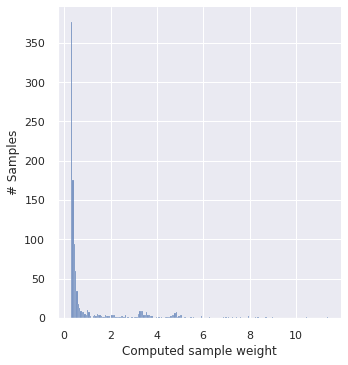

In [32]:
# prima cosa da fare è isolare i pesi dei soli dati di training
predictions_Z = predictions[:len(X_train)]
weights = (1./predictions_Z) - 1. 
weights /= np.mean(weights) # facciamo questo per normalizzare i pesi
sns.displot(weights, kde=False)
plt.xlabel('Computed sample weight')
plt.ylabel('# Samples')

In [ ]:
predictions_Z

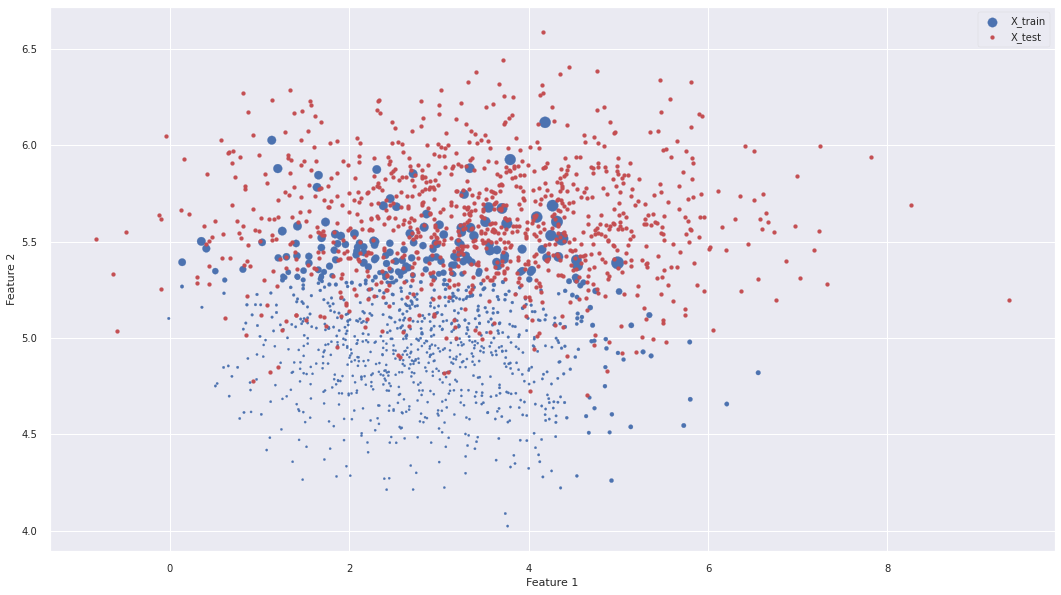

In [34]:
plt.ion()
plt.style.use('seaborn-notebook')
fig = plt.gcf()
fig.patch.set_facecolor('white')
fig.set_size_inches((18,10))
fig.set_facecolor("w")
ax = fig.add_subplot(111)

Zsize = 0.1 + weights*15
plt.scatter(X_train[:,0], X_train[:,1], marker='o', s=Zsize, c='b', label='X_train')
plt.scatter(X_test[:,0], X_test[:,1], marker='o', s=15, c='r', label='X_test')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

Successivamente useremo i pesi calcolati per modificare il dataset di training in modo tale da dare più importanza, in fase di creazione del modello di classificazione, ai record che si trovano più vicini ai dati di test.

**Link Utili**:
- https://www.youtube.com/c/AlfredoCanziani
- https://www.youtube.com/c/Codemotionworld
- https://www.youtube.com/playlist?list=PLUl4u3cNGP60IKRN_pFptIBxeiMc0MCJP (solo neuroscience)
- https://www.meetup.com/it-IT/deep-learning-italia-meetup-group/
- https://www.meetup.com/it-IT/machine-learning-milan/
- https://www.codemotion.com/
- https://www.coursera.org/

Gli eventi delì del Talent Garden su https://www.eventbrite.com/
